In [1]:
import numpy as np
from torch import nn
import torch
import math
from torch import optim

In [2]:
from preprocessing.audio_preprocessing import preprocess_song

In [3]:
# https://musicinformationretrieval.com/ipython_audio.html
import IPython.display as ipd
ipd.Audio('./data/input/Majulah.wav')

/Users/ffoo/personal_repos/audio_deep_embedding/src/preprocessing/audio_preprocessing.py:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, X = wavfile.read(input_file_path)


sample rate (Hz) = 44100
data shape = (1800166,)
duration_s = 40.820090702947844s
seconds per window: 0.023219954648526078
spectrogram time bins per sec: 43.0
full spectrogram shape : (513, 1757)
1
spectrogram subimage shape (time bins, freq bins): (88, 94)
['F', 'T', 'S_mag', 'dt', 'img_width', 'img_height', 'time_resolution']


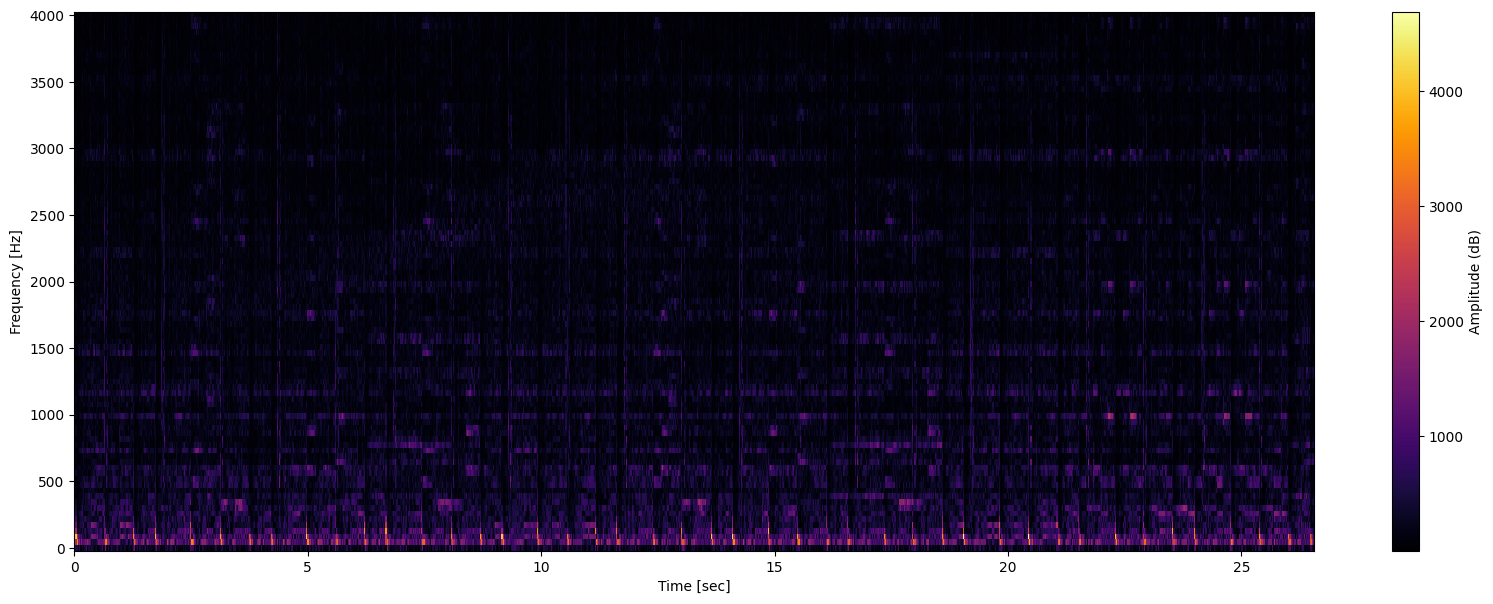

In [5]:
preprocess_song(input_file_path='./data/input/Majulah.wav', 
                output_file_path = './data/output/output.npz', 
                secs_per_img = 2)

In [6]:
latent_dim = 3
l = 45 # steps for Stack 1 input to be used for LSTM forecasting

# load dataset and variables
vars = np.load('./data/output/output.npz')
vars.files


['F', 'T', 'S_mag', 'dt', 'img_width', 'img_height', 'time_resolution']

In [7]:
S_mag_unnorm = vars['S_mag']
T = vars['T']
F = vars['F']
img_width = vars['img_width']  # time axis
img_height = vars['img_height']  # freq axis
img_size = (img_width, img_height)
dt = vars['dt']
time_resolution = vars['time_resolution']

# Params for window
t_start = int(dt*(l - 1))  # first frame index in the valid range
t_end = int(len(T) - img_width - dt - 1)  # last frame index in the valid range, assuming images start at t=0 and go to t=T-1
print(f't_start = {t_start}')
print(f't_end = {t_end}')
print(f'img_size = {img_size}')

t_start = 44
t_end = 1667
img_size = (array(88), array(94))


In [8]:
def normalize0_1(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

In [9]:
S_mag = normalize0_1(S_mag_unnorm)

In [10]:
S_mag.shape

(94, 1757)

In [11]:
# build generator of subimages of Spectrogram, sliding across time
def inputs_generator(t_start, t_end, S, dt_, img_height, img_width, l):

    t = t_start
    while t <= t_end:
        clip_tensor = [] # Input stack 1
        top_frames = [] # Input stack 2

        # Input stack 1
        # Generates (t-l) to (t) timesteps
        # For each batch of l timesteps -> Encoder -> LSTM which produces vhat_t
        # vhat_t used for Forecasting Loss
        for j in range(t - dt_*(l - 1), t + 1, dt_):
            sub_img = S[:img_height, j:j+img_width]
            clip_tensor.append(sub_img.astype(np.float32))  # pixel values are normalized to [0,1]
        clip_tensor = np.array(clip_tensor)

        # Input stack 2
        # Generates (t, t+1) timesteps 
        # (a) timestep (t) -> Encoder->decoder for Reconstruction Loss.
        # (b) timestep (t, t+1) -> Encoder. Latent representation of (t+1) - (t) equals v_t. v_t used for Forecasting Loss.
        for j in range(t, t + 2*dt_, dt_):
            sub_img = S[:img_height, j:j + img_width]
            top_frames.append(sub_img.astype(np.float32))
        top_frames = np.array(top_frames)

        yield ((clip_tensor, top_frames), 0)  # 0 represents the target output of the model. the metric in .compile is computed using this. the addloss layer outputs the loss itself just for convienience.
        t += dt_

In [12]:
from torch.utils.data import IterableDataset, DataLoader

class IterDataset(IterableDataset):
    def __init__(self, generator):
        self.generator = generator
        
    def __iter__(self):
        return self.generator

In [13]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(max_len, 1, d_model)

        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class CausalSelfAttention(nn.Module):

    def __init__(self, n_heads, head_embed, dropout_p):
        super().__init__()

        self.n_heads = n_heads
        self.head_embed = head_embed
        self.dropout_p = dropout_p
        
        self.qkv_proj = nn.Linear(head_embed * n_heads, 3 * head_embed * n_heads, bias = False)
        
        self.output_proj = nn.Linear(head_embed * n_heads, head_embed * n_heads)

        self.dropout_output = nn.Dropout(dropout_p)

    def forward(self, x):
        B, T, __input_dim = x.size()

        q, k, v = self.qkv_proj(x).chunk(3, dim = 2) # B, n_heads * head_embed -> 3 (B, head_embed)
        q = q.view(B, T, self.n_heads, self.head_embed).transpose(-2, -1) # B, T, head_embed, n_heads
        k = k.view(B, T, self.n_heads, self.head_embed).transpose(-2, -1) # B, T, head_embed, n_heads
        v = v.view(B, T, self.n_heads, self.head_embed).transpose(-2, -1) # B, T, head_embed, n_heads
        
        output = nn.functional.scaled_dot_product_attention(q, k, v, dropout_p = self.dropout_p, is_causal = True) # B, n_heads, T, head_embed
        output = output.transpose(1,2).contiguous().view(B, T, self.n_heads * self.head_embed)  # B, T, n_heads * head_embed)

        output = self.dropout_output(self.output_proj(output))

        return output
    
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_p):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features = input_dim, out_features = hidden_dim),
            nn.GELU(),
            nn.Linear(in_features = hidden_dim, out_features = input_dim),
            nn.Dropout(dropout_p)
        )
        
    def forward(self, x):
        output = self.layers(x)
        return output

class TransformerBlock(nn.Module):
    
    def __init__(self, n_heads, head_embed, dropout_p):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape = head_embed * n_heads)
        self.csa = CausalSelfAttention(n_heads, head_embed, dropout_p)
        self.layer_norm2 = nn.LayerNorm(normalized_shape = head_embed * n_heads)
        self.mlp = MLP(n_heads * head_embed, 4 * n_heads * head_embed, dropout_p)
    
    def forward(self, x):
        # Residual skip connections 
        x = x + self.csa(self.layer_norm1(x))
        x = x + self.mlp(self.layer_norm2(x))
        return x
    
class TransformerModel(nn.Module):

    def __init__(self, n_blocks, input_dim, n_heads, head_embed, dropout_p):
        super().__init__()
        # Input
        self.input_proj = nn.Linear(input_dim, n_heads * head_embed)
     
        self.pos_encoder = PositionalEncoding(d_model = n_heads * head_embed, dropout = dropout_p, max_len = 500)

        # Transformer
        self.layers = nn.Sequential(
            *[TransformerBlock(n_heads, head_embed, dropout_p) for i in range(n_blocks)]
        )

        # Output
        self.output_proj = nn.Linear(n_heads * head_embed, input_dim)

    def forward(self, x):
        # Input
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        
        # Tranformer processing
        x = self.layers(x)
        
        # Get only the last "hidden" state based on the last position
        x = x[:, -1,:]

        # Output
        x = self.output_proj(x)
        return x

In [14]:
class ConditionedModel(nn.Module):

    def __init__(self, input_dimensions, latent_dimensions, transformer_n_blocks, transformer_n_heads, transformer_head_embed, transformer_dropout_p):
        super().__init__()
        # Phase 1: Encoding to low dimension
        self.encoder_layers = nn.Sequential(
            # Conv1
            nn.Conv1d(in_channels = input_dimensions, out_channels = 32, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2),
            # Conv2
            nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2),
            # Conv3
            nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2),
            # Conv4
            nn.Conv1d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features = 896, out_features = latent_dimensions)
        )
        
        # Phase 2-1: Stack 1 for LSTM/Transformer Prediction
        self.transformer = TransformerModel(
            n_blocks = transformer_n_blocks, 
            input_dim = latent_dimensions,
            n_heads = transformer_n_heads, 
            head_embed = transformer_head_embed, 
            dropout_p = transformer_dropout_p)
        
        # Phase 2-2: Stack 2 for 
        self.decoder_layers = nn.Sequential(
            nn.Linear(in_features = latent_dimensions, out_features = 352, bias = False), # (Batch, 352)
            nn.Unflatten(dim = 1, unflattened_size = (32, 11)), # (Batch, channels = 32, length = 11)
            nn.Upsample(scale_factor = 2), # (Batch, channels = 32, length = 11 * 2 = 22)
            nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 'same'), # (Batch, 64, 22)
            nn.ReLU(),
            nn.BatchNorm1d(num_features=64), # Performs BatchNorm on Channel dimension. Output shape (Batch, 64, 22)
            nn.Upsample(scale_factor = 2), # (Batch, 64, 22*2 = 44)
            nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 'same'), # (Batch, 128, 44)
            nn.BatchNorm1d(num_features = 128), # (Batch, 128, 44)
            nn.Upsample(scale_factor = 2), # (Batch, 128, 88)
            nn.Conv1d(in_channels = 128, out_channels = input_dimensions, kernel_size = 1, stride = 1, padding = 'same'), # (Batch, input_dim, 88)
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        # X inputs
        x_stack1, x_stack2 = x
        
        # Stack 1 (Using Transformer based on CausalSelfAttention to predict velocity/differential in encoded space after Z_t using Z_(t-l+1) to Z_t)
        x_stack1 = self.encoder_layers(x_stack1)
        x_stack1 = self.transformer(x_stack1)
        v_t_hat = x_stack1[-1,:] 
        
        # Stack 2
        x_t = x_stack2[0]
        x_stack2_encoded = self.encoder_layers(x_stack2)
        x_stack2_encoded_decoded = self.decoder_layers(x_stack2_encoded)
        
        # Finding Encoder<>Decoded output of X_t
        x_t_hat = x_stack2_encoded_decoded[0]
        # Finding velocity/differential between encoded timesteps T vs T+1
        v_t = x_stack2_encoded[1] - x_stack2_encoded[0]
        
        return (v_t_hat, x_t, x_t_hat, v_t, x_stack2_encoded_decoded)
        

In [77]:
from torch.nn import CosineEmbeddingLoss

In [109]:
def loss_fn(output_y):
    v_t_hat, x_t, x_t_hat, v_t, _ = output_y
    
    alpha = 0.5
    beta = 0.5
    
    # MSE for recon
    loss_recon = torch.mean((x_t_hat - x_t) **2)
    
    # Cosine similarity for V
    loss_forecast_eval = CosineEmbeddingLoss()
    loss_forecast = loss_forecast_eval(v_t_hat.resize(1, v_t_hat.shape[0]), v_t.resize(1,v_t.shape[0]) , torch.ones(1))

    TOTAL_LOSS = alpha * loss_forecast + beta * loss_recon

    return alpha * loss_forecast + beta * loss_recon
    

In [110]:
from torch import optim

class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [111]:
batch_stack1 = 45
batch_stack2 = 2
image_width = 88
image_height = 94
input_dimensions = 94
latent_dimensions = 3
transformer_n_blocks = 5
transformer_n_heads = 6
transformer_head_embed = 8
transformer_dropout_p = 0.1
seq_len = 84

In [112]:
m = ConditionedModel(
    input_dimensions, 
    latent_dimensions,
    transformer_n_blocks,
    transformer_n_heads,
    transformer_head_embed,
    transformer_dropout_p)

optimizer = optim.Adam(m.parameters(), lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

for epoch_idx in range(5):
    
    print(f'Epoch IDX = {epoch_idx}')
    gen = inputs_generator(t_start = t_start, t_end= t_end, S = S_mag, dt_ = 1, img_height = img_height, img_width = img_width, l = 45)
    dataset = IterDataset(gen)

    for idx, loaded_data in enumerate(DataLoader(dataset, batch_size = 1)):
        x_pair, y = loaded_data
        x_pair = [x_pair[0].squeeze(), x_pair[1].squeeze()]
        optimizer.zero_grad()
        output_y = m(x_pair)
        loss_value = loss_fn(output_y)
        loss_value.backward()
        optimizer.step()
        lr_scheduler.step()
        if idx % 100 == 0:
            print(f'Epoch Idx = {epoch_idx}, Dataset Idx = {idx}, Loss Value = {loss_value}')
    print('-'*10)



Epoch IDX = 0
Epoch Idx = 0, Dataset Idx = 0, Loss Value = 0.4662187099456787
Epoch Idx = 0, Dataset Idx = 100, Loss Value = 0.35891640186309814
Epoch Idx = 0, Dataset Idx = 200, Loss Value = 0.9487194418907166
Epoch Idx = 0, Dataset Idx = 300, Loss Value = 0.30634379386901855
Epoch Idx = 0, Dataset Idx = 400, Loss Value = 0.19172403216362
Epoch Idx = 0, Dataset Idx = 500, Loss Value = 0.0013177166692912579
Epoch Idx = 0, Dataset Idx = 600, Loss Value = 0.9646452069282532
Epoch Idx = 0, Dataset Idx = 700, Loss Value = 0.9589916467666626
Epoch Idx = 0, Dataset Idx = 800, Loss Value = 0.08562485873699188
Epoch Idx = 0, Dataset Idx = 900, Loss Value = 0.007221125066280365
Epoch Idx = 0, Dataset Idx = 1000, Loss Value = 0.2374967634677887
Epoch Idx = 0, Dataset Idx = 1100, Loss Value = 0.9738721251487732
Epoch Idx = 0, Dataset Idx = 1200, Loss Value = 0.9630850553512573
Epoch Idx = 0, Dataset Idx = 1300, Loss Value = 0.014290514402091503
Epoch Idx = 0, Dataset Idx = 1400, Loss Value = 0.01

In [113]:
PATH = './model_output/m_initial.pt'
torch.save(m, PATH)

In [114]:
PATH = './model_output/m_initial.pt'
# Model class must be defined somewhere
model = torch.load(PATH)
model.eval()

ConditionedModel(
  (encoder_layers): Sequential(
    (0): Conv1d(94, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=896, out_features=3, bias=True)
  )
  (transformer): TransformerModel(
    (input_proj): Linear(in_features=3, out_features=48, bias=True)
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): Sequential(
      (0): TransformerBlock(
        (layer_norm1): LayerNorm((48,), eps=1e-05, e

In [120]:
gen = inputs_generator(t_start = t_start, t_end= t_end, S = S_mag, dt_ = 1, img_height = img_height, img_width = img_width, l = 45)

output_list = []
with torch.no_grad():
    for idx, x in enumerate(gen):
        input_x = torch.tensor(x[0][1])
        output_list.append(model.encoder_layers(input_x)[0])

print(output_list)

[tensor([-3.7982, -2.1197,  4.7750]), tensor([-4.0862, -2.1839,  5.0268]), tensor([-4.7405, -2.4052,  5.5954]), tensor([-5.0309, -2.5764,  5.9186]), tensor([-5.7113, -2.8774,  6.6430]), tensor([-5.8840, -2.9217,  6.7996]), tensor([-3.4158, -1.7511,  4.1749]), tensor([-4.1987, -2.1639,  5.0473]), tensor([-4.9886, -2.4886,  5.8862]), tensor([-5.2877, -2.5893,  6.2002]), tensor([-3.2161, -1.6496,  4.0429]), tensor([-4.0130, -2.0719,  4.9451]), tensor([-4.6093, -2.2934,  5.5744]), tensor([-4.7669, -2.3557,  5.7613]), tensor([-2.1992, -1.2796,  3.0207]), tensor([-2.5726, -1.4380,  3.4416]), tensor([-3.0791, -1.6206,  3.9810]), tensor([-3.2190, -1.6650,  4.1500]), tensor([-1.2339, -0.9345,  1.9861]), tensor([-1.5403, -1.1060,  2.3372]), tensor([-1.7473, -1.1946,  2.5862]), tensor([-1.8492, -1.2431,  2.7285]), tensor([-1.6827, -1.1151,  2.4515]), tensor([-1.8207, -1.1745,  2.5720]), tensor([-1.9879, -1.2537,  2.7592]), tensor([-2.1808, -1.3969,  3.0427]), tensor([-2.1330, -1.2815,  2.9257]), 

In [128]:
encoded_x_3d = np.array(output_list).T

In [129]:
encoded_x_3d.shape

(3, 1624)

In [138]:
encoded_x_3d.min(axis = 1)

array([-7.2363205, -3.6226857,  1.5678706], dtype=float32)

In [139]:
encoded_x_3d.max(axis = 1)

array([-0.8706992 , -0.82540154,  8.37108   ], dtype=float32)

In [ ]:
N = 1500
azim = [i*10 for i in range(1500)]

MovieWriter imagemagick unavailable; using Pillow instead.


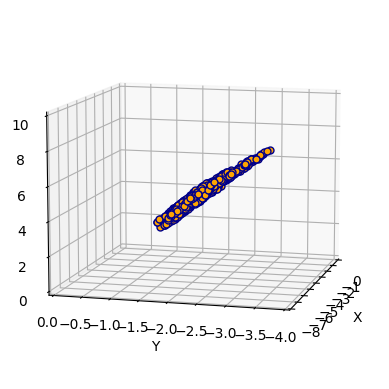

In [162]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def gen(n):
    phi = 0
    while phi < 2*np.pi:
        yield np.array([np.cos(phi), np.sin(phi), phi])
        phi += 2*np.pi/n

def update(num, data, line, azim, elev):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])
    ax.view_init(elev=elev[num], azim=azim[num])

data = encoded_x_3d

N = data.shape[1]
# data = np.array(list(gen(N))).T
line, = ax.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1], '-o', markerfacecolor='orange', mec='darkblue', markersize=5, linewidth=2, label='Z')
# line2, = ax.plot3D(Z[t-tail_points:t, 0], Z[t-tail_points:t, 1], Z[t-tail_points:t, 2], '-o', markerfacecolor='orange', mec='darkblue', markersize=12, linewidth=2, label='Z(t)')

# Setting the axes properties
ax.set_xlim3d([-8, 0])
ax.set_xlabel('X')

ax.set_ylim3d([-4, 0])
ax.set_ylabel('Y')

ax.set_zlim3d([0, 10])
ax.set_zlabel('T')

azim = [i*5 for i in range(N)]
elev = [10 for i in range(N)]

ani = animation.FuncAnimation(fig, update, N, fargs=(data, line, azim, elev), interval=30000/N, blit=False)
ani.save('matplot003.gif', writer='imagemagick')
plt.show()